In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.express as px
from wordcloud import WordCloud
import re
import nltk

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [23]:
file_path = 'Sarcasm_Headlines_Dataset_v2.json'

# Load the JSON file into a DataFrame using pandas
headings = pd.read_json(file_path, lines=True)

In [24]:
headings.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [25]:
headings = headings.drop('article_link', axis=1)


In [26]:
headings

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...
...,...,...
28614,1,jews to celebrate rosh hashasha or something
28615,1,internal affairs investigator disappointed con...
28616,0,the most beautiful acceptance speech this week...
28617,1,mars probe destroyed by orbiting spielberg-gat...


In [27]:
import re

# Convert 'comment' column to lowercase
headings['headline'] = headings['headline'].str.lower()

# Apply regex to remove unwanted patterns
headings['headline'] = headings['headline'].astype(str).apply(lambda x: re.sub('[^a-zA-Z\s]+|X{2,}', '', x))
headings['headline'] = headings['headline'].astype(str).apply(lambda x: re.sub("[@\^&\*\$]|#\S+|\S+[a-z0-9]\.(com|net|org)", " ", x))

In [28]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

# Expanding Contractions in the title, text
headings['headline'] = headings['headline'].apply(lambda x:expand_contractions(x))

In [29]:
headings['CharCount'] = headings['headline'].apply(lambda x: len(x))
headings['WordCount'] = headings['headline'].apply(lambda x: len(x.split()))

In [30]:
headings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   CharCount     28619 non-null  int64 
 3   WordCount     28619 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 894.5+ KB


In [31]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

There are 1769716 words in the combination of headline.


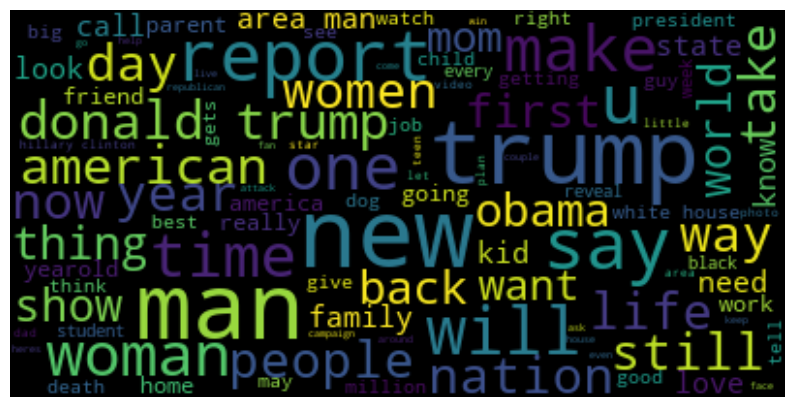

In [101]:
texts = " ".join(text for text in headings.headline)
print ("There are {} words in the combination of headline.".format(len(texts)))
# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100,
                      background_color="black").generate(texts)

# Display the generated image:
plt.figure(figsize = (10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Save the image in the img folder:
wordcloud.to_file("first_review.png")

In [70]:
import matplotlib.pyplot as plt

# Sample dataset (replace this with your own data)
dataset = headings['headline']

# Step 1: Process the dataset and count word frequencies
word_frequency = {}
words = dataset.lower().split()
for word in words:
    # Remove punctuation and special characters (optional, depending on your data)
    word = word.strip(".,!?")
    if word in word_frequency:
        word_frequency[word] += 1
    else:
        word_frequency[word] = 1

# Step 2: Sort the word frequencies in descending order
sorted_word_frequency = dict(sorted(word_frequency.items(), key=lambda item: item[1], reverse=True))

# Step 3: Choose the top N words you want to plot (let's say top 10 for this example)
top_n = 10
top_words = list(sorted_word_frequency.keys())[:top_n]
top_word_counts = list(sorted_word_frequency.values())[:top_n]

# Step 4: Plot the bar chart
plt.bar(top_words, top_word_counts)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title(f"Top {top_n} Words Frequency")
plt.xticks(rotation=45)
plt.show()


AttributeError: 'Series' object has no attribute 'lower'

In [33]:
def tokenize(text):
    # Remove punctuation characters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text) 
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens

In [34]:
X = headings.headline
Y = headings.is_sarcastic
# perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [35]:
import nltk
nltk.download(['punkt', 'wordnet'])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Tahor\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Tahor\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Create a smaller sample
sample_size = 10000
random_indices = np.random.choice(len(train_data), size=sample_size, replace=False)
train_data_sample = train_data[random_indices]
target_sample = target[random_indices]

In [36]:
# Instantiate transformers and classifier
vect = CountVectorizer(tokenizer=tokenize)
tfidf = TfidfTransformer()
clf = RandomForestClassifier()


# Fit and/or transform each to the training data
# Hint: you can use the fit_transform method
X_train_counts = vect.fit_transform(X_train)
X_train_tfidf = tfidf.fit_transform(X_train_counts)

# Fit or train the classifier
clf.fit(X_train_tfidf, y_train)

C:\Users\Tahor\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


RandomForestClassifier()

In [37]:
# Transform test data
X_test_counts = vect.transform(X_test)
X_test_tfidf = tfidf.transform(X_test_counts)

# Predict test labels
y_pred = clf.predict(X_test_tfidf)

In [38]:
print(classification_report(y_test.values, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.82      0.81      4916
           1       0.80      0.79      0.79      4529

    accuracy                           0.80      9445
   macro avg       0.80      0.80      0.80      9445
weighted avg       0.80      0.80      0.80      9445



In [39]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred)

0.8038094076308884

In [40]:
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
model = GaussianNB()

# Train the model using the training sets
model.fit(X_train_tfidf.toarray(), y_train)


# Predict test labels
y_pred = model.predict(X_test_tfidf.toarray())

print(classification_report(y_test.values, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.85      0.73      4916
           1       0.74      0.46      0.57      4529

    accuracy                           0.67      9445
   macro avg       0.69      0.66      0.65      9445
weighted avg       0.69      0.67      0.65      9445



In [41]:
roc_auc_score(y_test, y_pred)

0.6590592791307299

In [42]:
from sklearn import svm

In [43]:
model = svm.SVC(kernel='linear', gamma=1) 

# Train the model using the training sets
model.fit(X_train_counts, y_train)

# Predict test labels
y_pred = model.predict(X_test_counts.toarray())

print(classification_report(y_test.values, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      4916
           1       0.82      0.80      0.81      4529

    accuracy                           0.82      9445
   macro avg       0.82      0.82      0.82      9445
weighted avg       0.82      0.82      0.82      9445



In [37]:
roc_auc_score(y_test, y_pred)

0.8229754509080744

In [44]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 3)

# Train the model using the training sets
knn.fit(X_train_tfidf.toarray(), y_train)

# Predict test labels
y_pred = knn.predict(X_test_tfidf.toarray())

print(classification_report(y_test.values, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.84      0.76      4916
           1       0.78      0.60      0.68      4529

    accuracy                           0.73      9445
   macro avg       0.74      0.72      0.72      9445
weighted avg       0.73      0.73      0.72      9445



In [45]:
roc_auc_score(y_test, y_pred)

0.7216105377136511

In [46]:
from transformers import BertTokenizer, BertModel
import torch
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

In [47]:
tokenizer = BertTokenizer.from_pretrained('prajjwal1/bert-tiny')

In [48]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, X, Y):

        self.labels = np.array(Y)
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512,
                                # truncation=True,
                                return_tensors="pt") for text in X]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y


In [49]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('prajjwal1/bert-tiny')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(128, 2)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [50]:
def train(model, X,Y, learning_rate, epochs, batch_size):

    train = Dataset(X,Y)
    # , Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size, shuffle=True)
    # val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
           
    print(f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(X): .3f} | Train Accuracy: {total_acc_train / len(X): .3f}')
                      

In [51]:
def evaluate(model, X,Y, batch_size):

    test = Dataset(X, Y)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size,shuffle=False)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    y_pred = []
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)
            y_pred.append(output.argmax(dim=1))

    return y_pred

In [52]:
EPOCHS = 5
batch_size = 32
model = BertClassifier()
LR = 1e-4
              
train(model, X_train, y_train, LR, EPOCHS, batch_size)

100%|██████████| 600/600 [12:21:58<00:00, 74.20s/it]        

Epochs: 5 | Train Loss:  0.001 | Train Accuracy:  0.990


In [54]:
y_pred = evaluate(model, X_test,y_test, batch_size)

In [55]:
y_pred_ = torch.cat(y_pred, dim=0)

In [56]:
y_pred_=y_pred_.cpu().detach().numpy()

In [92]:
print(classification_report(y_test.values, y_pred_))
print(roc_auc_score(y_test, y_pred_))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87      4916
           1       0.87      0.84      0.86      4529

    accuracy                           0.86      9445
   macro avg       0.87      0.86      0.86      9445
weighted avg       0.86      0.86      0.86      9445

0.8635293060308749


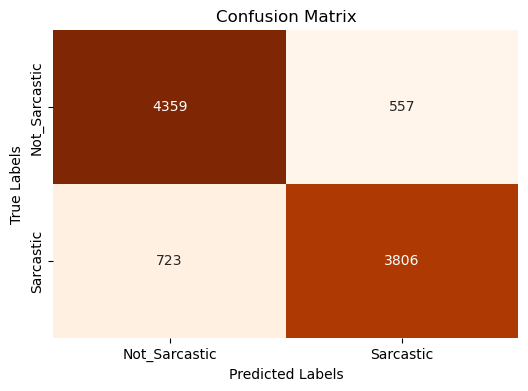

In [89]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming you already have the ground truth 'y_test' and the predicted labels 'y_pred_'
# Ensure that 'y_test' and 'y_pred_' are NumPy arrays or can be converted to NumPy arrays

# Convert the predicted probabilities to binary labels based on a threshold (0.5 in this case)
threshold = 0.5
y_pred_binary = (y_pred_ >= threshold).astype(int)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Define class labels (modify these based on your specific problem)
class_labels = ['Not_Sarcastic', 'Sarcastic']

# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

# Plot the confusion matrix as a table
plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Oranges', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



In [91]:
print(type(X_test))
print(type(y_test))


<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
